# Towards Sheaf Contextuality for Quantum Machine Learning
#### Quantum Learning Models for Predicting Contextuality

## 1. Introduction

What is the defining feature that distinguishes quantum from classical information processing?  One possible answer is enshrined in the now Nobel Prize winning inequalities proposed by John Bell.  These inequalities demonstrated that the statistics generated by certain quantum systems contained correlations that could not be generated by any classical sources.  Bell's work was arguably the catalyst to launch what is now known as the 'second quantum revolution'.

We're now a few decades past Bell's achievement and into the era of NISQ and parameterized quantum circuits.  If contextuality is the key difference between the quantum and classical world, how do we utilize it to design better quantum information processing systems?  This question was recently given an answer in [1] for quantum machine learning.  In [1], the authors extend the framework of 'generalized contextuality' proposed in [2] and apply it to both classical and quantum learning models.  The idea here is twofold.  First, to design quantum learning models that perform better than their classical counterparts we should look for data that exhibits contextuality.  Second, once we have such contextual data we should then encode that structure as an inductive bias in our quantum learning model.  The authors of [1] show for a toy model that a quantum learning model with a contextual inductive bias out performs a classical surrogate on data that exhibits contextuality.

The results of [1] suggest that there should be many more instances of contextual data that a quantum learning model can be tailored to.  One such instance can be found in the phenomenon of polysemy in natural language.  Polysemy is when a word or phrase has more than one possible meaning.  When polysemous words are combined into a phrase, the meaning selected for the phrase may not be predictive of the meaning of the component words.  For example, consider the phrase 'power plant' [3].  Each word 'power' and 'plant' are associated with a range of meanings with a frequency distribution.  Consider the meaning with highest frequency for each word. When the two words are combined into the phrase 'power plant', meanings for both 'power' and 'plant' are selected.  The highest frequency meanings of each word in the composite is not the same as the highest frequency meanings for each word individually.  In other words, the combination of meanings exhibits contextuality.  The approach of [3] uses the sheaf theoretic approach to contextuality first proposed in [4].  Although distinct from the generalized contextuality of [2], recent work suggests that the two are equivalent and can be translated between each other [5].

Can we leverage the recent success of natural language processing on quantum computers [7], [8] to learn a quantum model for contextual natural language data? In what follows, we'll take steps towards such models on a pair of datasets.  The first dataset [8] consists of pairs of phrases that are combined into a compound phrase whose meaning is ambiguous.  Annotators are then asked to rate how well the two meanings are consistent with each other.  We turn these into the emprical models of [4] and train a parameterized quantum circuit to reproduce its entries. We use a variation on the lambeq pipeline [9] to turn input sentences into PennyLane quantum circuits.  For the second dataset we use the computed empirical models of [10] downloaded from [11].  Again, we train parameterized quantum circuits to reproduce its entries.  For an example of an emprical model see Figure 1.


![Alt text](word-pair-empircal-model.png "a title") 
*Figure 1: An example empirical model from [10]. Here the measurement contexts are different combinations of words. Each word has two possible meanings (ie, measurement outcomes) which is tabulated in the columns.  The resulting probability distribution for each row is computed.*  In what follows we encode each measurement context as a parameterized quantum circuit and train the model to reproduce the table.

## 2. Contextuality in Word Sense Copredication

We first run experiments on the word sense copredication dataset of [8].

### 2.1 Prepare the training data 
We pick 50 sentences, each rated by the same four annotators.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

worker_10 = pd.read_json("polyseme_copredication.json").transpose()[pd.read_json("polyseme_copredication.json").transpose()["worker"] == "worker_10"]
worker_7 = pd.read_json("polyseme_copredication.json").transpose()[pd.read_json("polyseme_copredication.json").transpose()["worker"] == "worker_7"]
worker_14 = pd.read_json("polyseme_copredication.json").transpose()[pd.read_json("polyseme_copredication.json").transpose()["worker"] == "worker_14"]
worker_19 = pd.read_json("polyseme_copredication.json").transpose()[pd.read_json("polyseme_copredication.json").transpose()["worker"] == "worker_52"]

keys = []
workers ={10:worker_10["judgements"],7:worker_7["judgements"],14:worker_10["judgements"],19: worker_19["judgements"]}
contexts = [[10,14],[10,19],[7,14],[7,19]]
for i in range(5):
    keys.append(list(worker_10["judgements"].values[i].keys()))

sentences = {}
for i in range(5):
    tmp_keys = keys[i]
    for j in range(len(tmp_keys)):
        sentence = workers[10].values[i][tmp_keys[j]]["copredication"]
        sentences[sentence] = []
        for c in contexts:
            a = workers[c[0]].values[i][tmp_keys[j]]["rating"]
            b = workers[c[1]].values[i][tmp_keys[j]]["rating"]
            sentences[sentence].append([a,b])

sentences_to_remove = ["The school was well respected among researchers and informed parents about this year's events.",
                       "War of the Worlds was originally written in English and informed parents about this year’s events.",
                       "The school was painted during the holidays and informed parents about this year’s events.",
                       "The Guardian fired its editor in chief and was first published in 1898.",
                       "The Guardian contains advertisements and is a staple of science fiction writing."]

for i in sentences_to_remove:
    sentences.pop(i)
    

train_data = list(sentences.keys())


### 2.2 Convert sentences into PennyLane circuits.
Here we modify a few functions in the lambeq pipeline [9] to make it easier to control the resulting PennyLane QNode.

In [4]:
import pandas as pd
import pennylane as qml
import lambeq
import nltk

from discopy.tensor import Tensor
import pennylane.numpy as np

import discopy

from lambeq import BobcatParser
from lambeq import remove_cups
from lambeq import AtomicType, IQPAnsatz

parser = BobcatParser(verbose='text')

In [5]:
from pytket import OpType

OP_MAP = {
    OpType.X: qml.PauliX,
    OpType.Y: qml.PauliY,
    OpType.Z: qml.PauliZ,
    OpType.S: qml.S,
    OpType.Sdg: lambda wires: qml.S(wires=wires).inv(),
    OpType.T: qml.T,
    OpType.Tdg: lambda wires: qml.T(wires=wires).inv(),
    OpType.H: qml.Hadamard,
    OpType.Rx: qml.RX,
    OpType.Ry: qml.RY,
    OpType.Rz: qml.RZ,
    OpType.CX: qml.CNOT,
    OpType.CY: qml.CY,
    OpType.CZ: qml.CZ,
    OpType.CRx: qml.CRX,
    OpType.CRy: qml.CRY,
    OpType.CRz: qml.CRZ,
    OpType.CU1: lambda a, wires: qml.ctrl(qml.U1(a, wires=wires[1]),
                                          control=wires[0]),
    OpType.SWAP: qml.SWAP,
    OpType.noop: qml.Identity,
}

In [18]:
from discopy.quantum import pennylane as d_pl

def make_pennylane_qnode(disco_circuit,context):
    symbols = disco_circuit.free_symbols
    str_map = {str(s): s for s in symbols}
    tk_circ = disco_circuit.to_tk()
    #op_list, params_list, wires_list = discopy.quantum.pennylane.extract_ops_from_tk(tk_circ,str_map)


    op_list, params_list, wires_list = [], [], []

    for op in tk_circ.__iter__():
        if op.op.type != OpType.Measure:
            op, params, wires = d_pl.tk_op_to_pennylane(op, str_map)
            #print(params)
            op_list.append(op)
            params_list.append([p/2 for p in params])
            wires_list.append(wires)

    
    param_indexes = []
    vocab_indexes = []
    params = []
    #print(params_list)
    for i in range(len(params_list)):
        if params_list[i] != []:
            v_index = vocab.index(params_list[i][0])
            param_indexes.append(i)
            vocab_indexes.append(v_index)
    
    def qfunc(params):
        count = 0
        for i in range(len(op_list)):
            if i in param_indexes:
                op_list[i](params[vocab_indexes[count]],wires=wires_list[i])
                count += 1
            else:
                op_list[i](wires=wires_list[i])
    
    
    n_qubits = tk_circ.n_qubits
    
    dev = qml.device("default.qubit",wires = tk_circ.n_qubits)
    def circuit(params):
        qfunc(params)
        if context == 'ZZ':
            return qml.expval(qml.PauliZ(n_qubits-2)),qml.expval(qml.PauliZ(1))
        if context == 'ZX':
            return qml.expval(qml.PauliZ(n_qubits-2)),qml.expval(qml.PauliX(1))
        if context == 'XZ':
            return qml.expval(qml.PauliX(n_qubits-2)),qml.expval(qml.PauliZ(1))
        if context == 'XX':
            return qml.expval(qml.PauliX(n_qubits-2)),qml.expval(qml.PauliX(1))
    qnode = qml.QNode(circuit,dev)
    
    
    
    
    return qnode

Parse the sentences into string diagrams.

In [7]:
raw_diagrams = []

for i in train_data:
    diagram = parser.sentences2diagrams([i])
    raw_diagrams.append(diagram[0])

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees

lambeq comes with a collection of rewrite rules to simplify the string diagrams.  This is important for the downstream task of converting the string diagrams into parameterized quantum circuits.

In [8]:
from lambeq import Rewriter

train_diagrams = []
for diagram in raw_diagrams:
    rewriter = Rewriter(['prepositional_phrase', 'determiner','postadverb','preadverb','object_rel_pronoun'])
    rewritten_diagram = rewriter(diagram)
    normalised_diagram = rewritten_diagram.normal_form()
    curry_functor = Rewriter(['curry'])
    diagram = curry_functor(normalised_diagram).normal_form()
    train_diagrams.append(diagram)

We use the IQP ansatz to convert our string diagrams into parameterized quantum circuits.

In [9]:
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1,AtomicType.PREPOSITIONAL_PHRASE:1},
                   n_layers=3, n_single_qubit_params=4)

train_circuits = []

for i in range(len(train_diagrams)):
    train_circuits.append(ansatz(train_diagrams[i]))
 

Initialize parameters for training.

In [11]:
from sympy import default_sort_key
all_circuits = train_circuits

vocab = sorted(
   {sym for circ in all_circuits for sym in circ.free_symbols},
    key=default_sort_key
)
params = np.array([np.random.rand(1) for w in vocab])

For each sentence circuit we encode the annotators responses into the expectation value of Pauli operators.

In [19]:
pl_circuits = []
to_remove = []

contexts = ['ZZ','XZ','ZX','XX']

for i in range(len(train_circuits)):
    if len(pl_circuits) == 45*4: 
        to_remove.append(i)
    else:
        try:
            for c in contexts:
                circuit = make_pennylane_qnode(train_circuits[i],c)
                pl_circuits.append(circuit)
        except:
            to_remove.append(i)

In [20]:
train_labels = []
count = 0
for i in list(sentences.keys()):
    if count in to_remove:
        count +=1
        continue
    else: 
        train_labels.append(sentences[i])
        count +=1


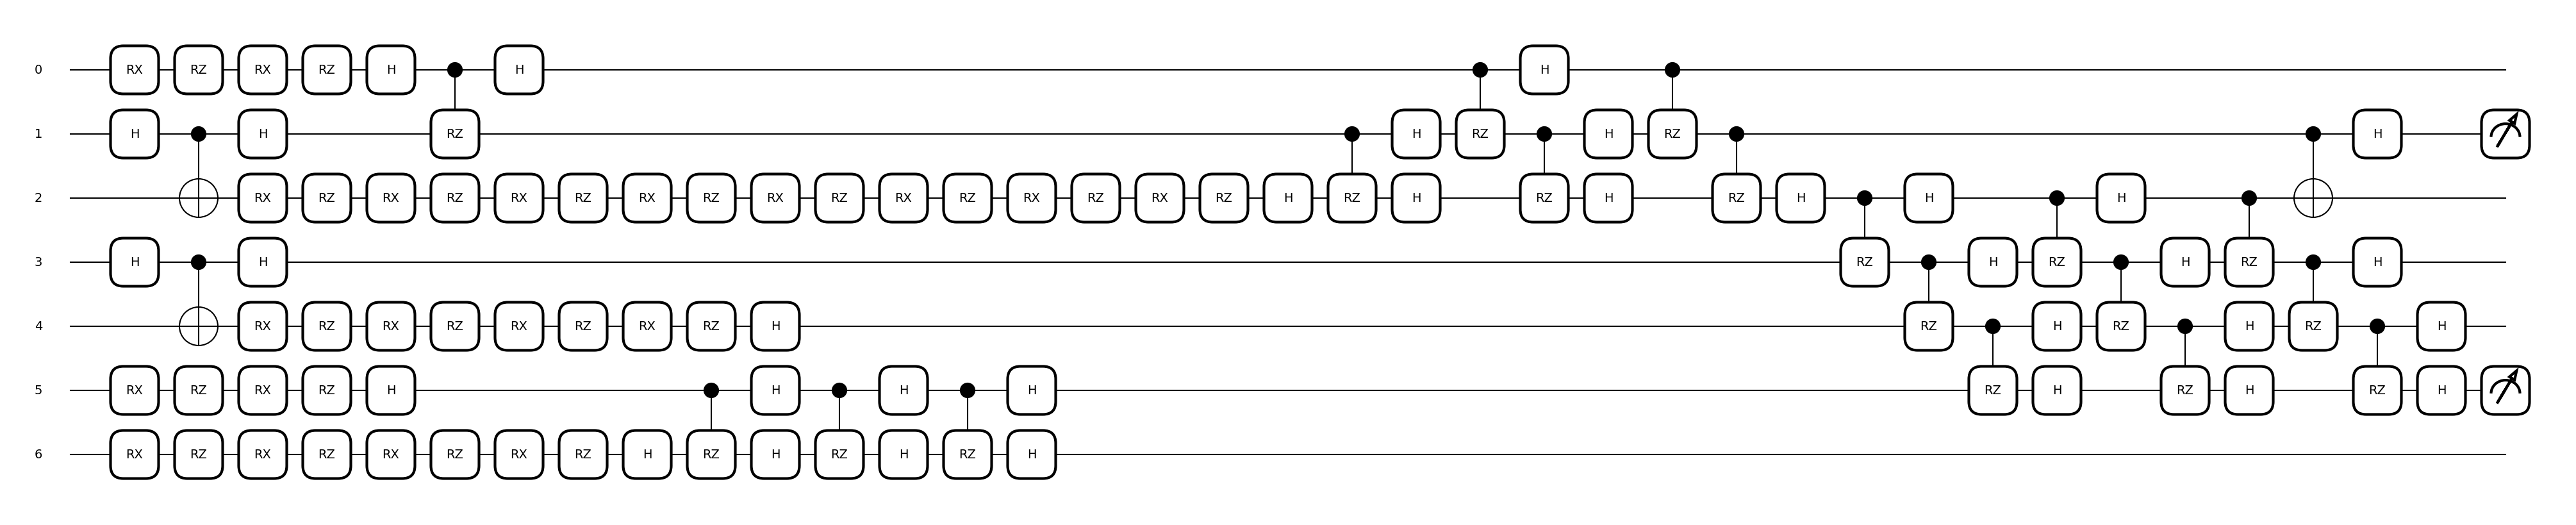

In [21]:
fig, ax = qml.draw_mpl(pl_circuits[10])(params)
plt.show()

In [ ]:
train_targets = []
for i in train_labels:
    for j in i:
        train_targets.append([int(k) for k in j])

train_targets = np.array(train_targets)

### 2.3 Train the model


Train the model. We use the gradient descent optimizer and mean squared error as the loss function.

In [22]:
import numpy as npp
def my_norm(a):
    ratio = 2/(npp.max(a)-npp.min(a)) 
    #as you want your data to be between -1 and 1, everything should be scaled to 2, 
    #if your desired min and max are other values, replace 2 with your_max - your_min
    shift = (npp.max(a)+npp.min(a))/2 
    #now you need to shift the center to the middle, this is not the average of the values.
    return (a - shift)*ratio

In [23]:
def cost(pl_circuits,params,train_targets):
    predictions =  np.array([c(params) for c in pl_circuits]).reshape(360,1)
    cost = np.sum((train_targets-predictions)**2)/ len(train_targets)
    return cost

In [ ]:
train_targets = my_norm(train_targets.reshape(360,1))

In [ ]:
opt = qml.GradientDescentOptimizer(stepsize=0.25)

In [ ]:
loss_list = []

for n in range(1000):
        pl_circuits,params,_ = opt.step(cost,pl_circuits,params,train_targets)
  
        loss_list.append(cost(pl_circuits,params,train_targets))

        print(loss_list[-1])
        
        if n % 10 == 0:
            np.save('params_copredicate.npy', params)  
            

## 3. Contextuality of Lexically Ambiguous Phrases

### 3.1 Prepare the training data 


In [25]:
data =pd.read_json("VO.json")
columns = data.columns.values

sentences = {}

for i in range(len(columns)):
    sentence = " ".join(columns[i].split("_"))
    sentences[sentence] = data[columns[i]]["model"]

### 3.2 Convert sentences into PennyLane circuits.
We follow the same steps from section 2.  We modify the function `make_pennylane_qnode` slightly.

In [28]:
train_data = list(sentences.keys())
raw_train_diagrams = parser.sentences2diagrams(train_data)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [29]:
from discopy.quantum import pennylane as d_pl

def make_pennylane_qnode(disco_circuit,context):
    symbols = disco_circuit.free_symbols
    str_map = {str(s): s for s in symbols}
    tk_circ = disco_circuit.to_tk()
    #op_list, params_list, wires_list = discopy.quantum.pennylane.extract_ops_from_tk(tk_circ,str_map)


    op_list, params_list, wires_list = [], [], []

    for op in tk_circ.__iter__():
        if op.op.type != OpType.Measure:
            op, params, wires = d_pl.tk_op_to_pennylane(op, str_map)
            #print(params)
            op_list.append(op)
            params_list.append([p/2 for p in params])
            wires_list.append(wires)

    
    param_indexes = []
    vocab_indexes = []
    params = []
    #print(params_list)
    for i in range(len(params_list)):
        if params_list[i] != []:
            v_index = vocab.index(params_list[i][0])
            param_indexes.append(i)
            vocab_indexes.append(v_index)
    
    def qfunc(params):
        count = 0
        for i in range(len(op_list)):
            if i in param_indexes:
                op_list[i](params[vocab_indexes[count]],wires=wires_list[i])
                count += 1
            else:
                op_list[i](wires=wires_list[i])
    
    
    n_qubits = tk_circ.n_qubits
    
    dev = qml.device("default.qubit",wires = tk_circ.n_qubits)
    def circuit(params):
        qfunc(params)
        if context == 'ZZ':
            return qml.probs(wires=[1,n_qubits-2])
        if context == 'ZX':
            qml.Hadamard(n_qubits-2)
            return qml.probs(wires=[1,n_qubits-2])
        if context == 'XZ':
            qml.Hadamard(1)
            return qml.probs(wires=[1,n_qubits-2])
        if context == 'XX':
            qml.Hadamard(1)
            qml.Hadamard(n_qubits-2)
            return qml.probs(wires=[1,n_qubits-2])
        
        
    qnode = qml.QNode(circuit,dev)
    
    
    
    
    return qnode

In [30]:
ansatz = IQPAnsatz({AtomicType.NOUN: 3, AtomicType.SENTENCE: 1},
                   n_layers=3, n_single_qubit_params=3)

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]

train_circuits = [ansatz(diagram) for diagram in train_diagrams]

In [31]:
from sympy import default_sort_key
all_circuits = train_circuits

vocab = sorted(
   {sym for circ in all_circuits for sym in circ.free_symbols},
    key=default_sort_key
)
params = np.array([np.random.rand(1) for w in vocab])

In [ ]:
pl_circuits = []

contexts = ['ZZ','XZ','ZX','XX']

for i in range(len(train_circuits)):
    for c in contexts:
            circuit = make_pennylane_qnode(train_circuits[i],c)
            pl_circuits.append(circuit)

In [ ]:
fig, ax = qml.draw_mpl(pl_circuits[55])(params) 

### 3.3 Training the model.
This time we use the cross entropy loss for our cost function.  For demonstration purposes we select the first 100 empirical models for training.

In [ ]:
lst = list(sentences.keys())

target_labels = []
for i in lst:
    tst = sentences[i]
    for j in tst:
        target_labels.append(j)
        
train_targets = np.array(target_labels)

In [ ]:
final_circuits = pl_circuits[:100]
final_targets = train_targets[:100]

In [ ]:
def cost(pl_circuits,params,train_targets):
    predictions =  np.array([c(params) for c in pl_circuits])
    cost = -np.sum(train_targets * np.log2(predictions)) / len(train_targets)
    return cost

In [ ]:
loss_list = []

for n in range(10000):
    
        pl_circuits,params,_ = opt.step(cost,final_circuits,params,final_targets)
     
        loss_list.append(cost(final_circuits,params,final_targets))
        
        if n % 10 == 0:
            np.save('params_lexical.npy', params) 

        print(loss_list[-1])

## 4. Conclusion

Model weights for each dataset are saved as `params_copredication.npy` and `params_lexical.npy`.  Due to time constraints we could only complete a partial training, although initial results are promising.  There are many open lines of research to pursue here, including: 

- Do the quantum learning models generalize to empirical models not in the training data?
- Using the proposed translation mechanism in [5], can these empirical models be translated into the form used in [1]?
- In [1], the authors propose two ways to encode the contextuality of a dataset as an inductive bias in the quantum learning model.  Can something similar be done with the contextuality exhibited by empirical models? For instance, [10] uses the contextuality and causal fraction measures to detect nonclassical behaviour in their empirical models. Can we encode the contextuality fraction of a empirical model as an inductive bias?

These are just a few of the many open questions for the burgeoning field of contextual machine learning.  We hope that this notebook provides some inspiration and motivation.

## References

[1] Joseph Bowles et al. "Contextuality and inductive bias in quantum machine learning". In: arXiv preprint arXiv:2302.01365 (2023)

[2] Robert W Spekkens. “Contextuality for preparations, transformations, and unsharp mea-
surements”. In: Physical Review (2005)

[3] Daphne Wang et al. "On the Quantum-like Contextuality of Ambiguous Phrases". In: arXiv preprint arXiv:2107.14589

[4] Samson Abramsky and Adam Brandenburger. "The sheaf theoretic structure of non-locality and contextuality". In: New J. Phys. (2011)

[5] Linde Wester. "Almost Equivalent Paradigms of Contextuality". In: arXiv preprint arXiv:1708.00843 (2018)
        
[6] Bob Coeke et al. "Foundations for Near-Term Quantum Natural Language Processing". In: arXiv preprint arXiv:2012.03755 (2020)

[7] Amin Karamlou, Marcel Pfaffhauser, James Wootton. "Quantum Natural Language Generation on Near-Term Devices". In: arXiv preprint arXiv:2211.00727

[8] Janosch Haber and Massimo Poesio. "Word Sense Distance in Human Similarity Judgements and Contextualised Word Embeddings".  In: Proceedings of the Probability and Meaning Conference (2020)

[9] Dimitri Kartsaklis et al. "lambeq: An Efficient High-Level Python Library for Quantum NLP". In: arXiv preprint arXiv:2110.04236

[10] Daphne Wang and Mehrnosh Sadrzadeh. "The Causal Structure of Semantic Ambiguities". In: arXiv preprint arXiv:2206.06807 (2022)

[11] Daphne Wang. "Causality of lexically ambiguous phrases". In: https://github.com/wangdaphne/Causality-of-lexically-ambiguous-phrases